Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

In [51]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.dummy import DummyRegressor

from numpy.random import RandomState
from matplotlib import pyplot as plt


## Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).


Описание данных
Данные состоят из файлов, полученных из разных источников:

data_arc_new.csv — данные об электродах;

data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

data_gas_new.csv — данные о продувке сплава газом;

data_temp_new.csv — результаты измерения температуры;

data_wire_new.csv — данные о проволочных материалах (объём);

data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.


In [102]:
electrode = pd.read_csv('/datasets/data_arc_new.csv')

syp_materials_ob = pd.read_csv('/datasets/data_bulk_new.csv')

syp_materials_time = pd.read_csv('/datasets/data_bulk_time_new.csv')

gas = pd.read_csv('/datasets/data_gas_new.csv')

izmer_temp = pd.read_csv('/datasets/data_temp_new.csv')

provol_material_ob = pd.read_csv('/datasets/data_wire_new.csv')

provol_material_time = pd.read_csv('/datasets/data_wire_time_new.csv')

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>Как говорится, данные на базе)

## Исследовательсский анализ

### electrode  данные об электродах;

In [103]:

electrode.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [104]:
electrode.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [105]:
electrode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


-перевести в datetime

-пропусков нет

-повтор key
(еоличество итераций обработки материала)



count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

<AxesSubplot:>

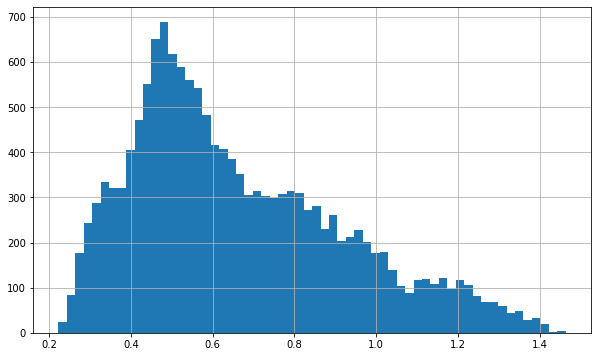

In [106]:
display(electrode['Активная мощность'].describe())
electrode['Активная мощность'].hist(bins=60, figsize=(10,6))

In [107]:
#распределение нормальное, выбросов нет



In [108]:
# приведем тип для работы с датой
electrode['Начало нагрева дугой'] = pd.to_datetime(electrode['Начало нагрева дугой'] )
electrode['Конец нагрева дугой'] = pd.to_datetime(electrode['Конец нагрева дугой'] )
#наверно это буду делать в предобработке

### syp_materials_ob — данные о подаче сыпучих материалов (объём);

In [109]:
display(syp_materials_ob.head())
syp_materials_ob.info()
syp_materials_ob.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<AxesSubplot:>

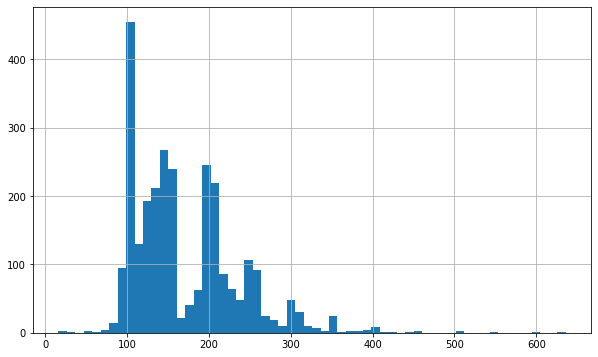

In [110]:
syp_materials_ob['Bulk 14'].hist(bins=60, figsize=(10,6))

-очень много пропусков

-уникальные ключи




### syp_materials_time — данные о подаче сыпучих материалов (время);

In [111]:
display(syp_materials_time.head())
syp_materials_time.info()
syp_materials_time.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


-перевести в datetime

-много пропусков


### gas — данные о продувке сплава газом;

In [112]:
display(gas.head())
gas.info()
gas.describe()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


-пропусков нет

-уникальный ключ

<AxesSubplot:>

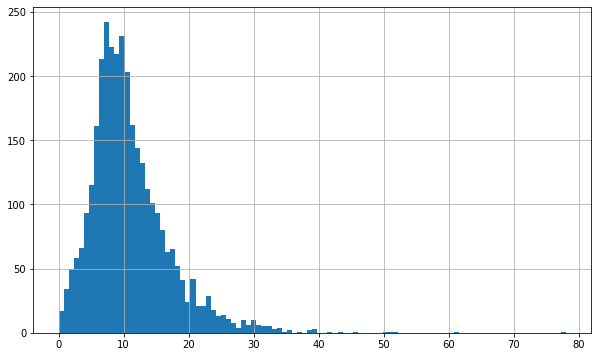

In [113]:
gas['Газ 1'].hist(bins=100, figsize=(10,6))

-есть выбросы после 40

In [114]:
#удалить выброс после 30


### izmer_temp — результаты измерения температуры;

In [115]:
display(izmer_temp.head())
izmer_temp.info()
izmer_temp.describe()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [116]:
izmer_temp['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

-изменить тип datetime

-пропуски в температуре 

-ключ уникальный

<AxesSubplot:>

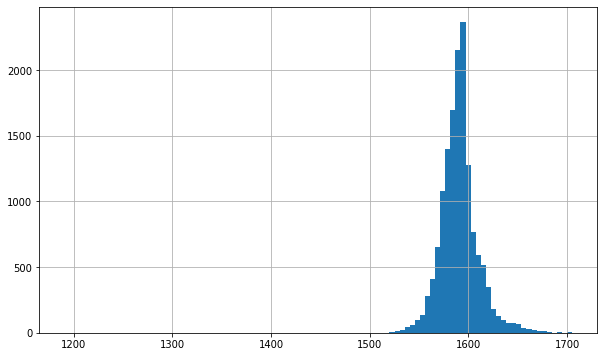

In [117]:
izmer_temp['Температура'].hist(bins=100, figsize=(10,6))

In [118]:
izmer_temp[izmer_temp['Температура'] <= 1500].count()

key             5
Время замера    5
Температура     5
dtype: int64

### provol_material_ob — данные о проволочных материалах (объём);

In [119]:
display(provol_material_ob.head())
provol_material_ob.info()
provol_material_ob.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<AxesSubplot:>

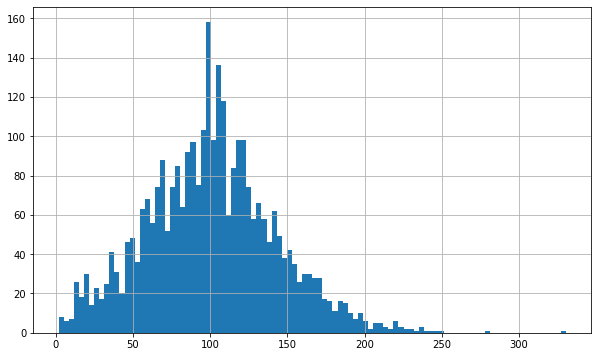

In [120]:
provol_material_ob['Wire 1'].hist(bins=100, figsize=(10,6))

-очень много пропусков

-ключ уникальный

### provol_material_time — данные о проволочных материалах (время).

In [121]:
display(provol_material_time.head())
provol_material_time.info()
provol_material_time.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [122]:

pd.DataFrame(provol_material_time.isna().sum(), columns = ['пропусков']).style.background_gradient()

,пропусков
key,0
Wire 1,26
Wire 2,2002
Wire 3,3018
Wire 4,3067
Wire 5,3080
Wire 6,3008
Wire 7,3070
Wire 8,3062
Wire 9,3052


-оооочень большое количество пропусков

-перевести в datetime

In [123]:
provol_material_time['Wire 1'] = pd.to_datetime(provol_material_time['Wire 1'] )

<AxesSubplot:>

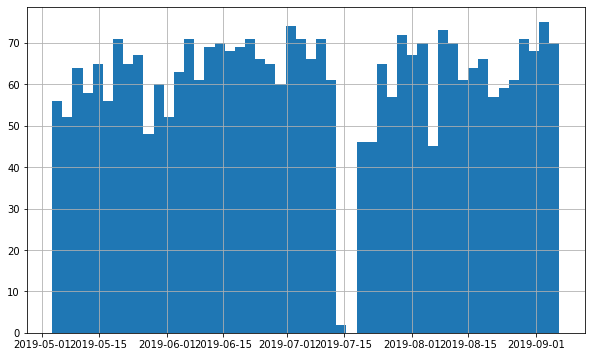

In [124]:
provol_material_time['Wire 1'].hist(bins=50, figsize=(10,6))

In [125]:
provol_material_time['Wire 1'].describe()

/tmp/ipykernel_31/4139899488.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  provol_material_time['Wire 1'].describe()


count                    3055
unique                   3055
top       2019-05-25 04:54:17
freq                        1
first     2019-05-03 11:06:19
last      2019-09-06 17:10:06
Name: Wire 1, dtype: object

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
ОК, Эллина, с первичным анализом - понятно. Есть и аналитика, и локальные выводы!! Это верно.<br>
    
Добавь, пожалуйста: Графический анализ по  присадкам (гистограммы) и общий вывод по разделу, важно знать какое качество данных - что ожидается в предобработке. Буду ждать со следующей итерацией)<br><br>
    
По вопросу ниже: на встрече сегодня обсудили его и некоторые другие. Оставлись ещё вопросы?<br>
БУДУ ЖДАТЬ)

## Общий вывод по исследовательскому анализу

Целевой признак: конечная температура стали ( таблица - izmer_temp)

Будут удалены выбросы в gas 

В присыпках заполнены nanы - 0

Найти полную мощность (удалить 2 других признака?)

Таблица будет объединена по key

После объединения таблиц, при отсутствии целевого признака, удалены все эти значения из общей таблицы

Удалены данные с датой

Посмотреть корреляцию до начала обучения моделей

На этом предобработка данных будет закончена




## Предобработка данных

### Удалим выбросы

In [126]:
#реактивная мощность
electrode[electrode['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [127]:

electrode = electrode[electrode['Реактивная мощность'] > 0]

In [128]:
electrode.describe()

,key,Активная мощность,Реактивная мощность
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.662749,0.487115
std,934.593897,0.258894,0.197612
min,1.000000,0.223120,0.153777
25%,806.000000,0.467115,0.337190
50%,1617.000000,0.599578,0.441665
75%,2429.000000,0.830135,0.608223
max,3241.000000,1.463773,1.270284


<AxesSubplot:>

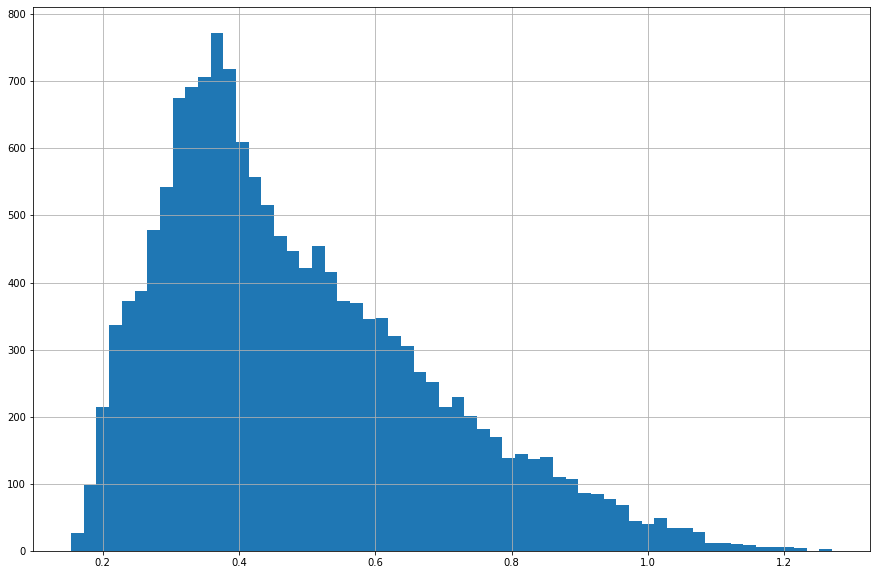

In [129]:
electrode['Реактивная мощность'].hist(bins=60, figsize=(15,10))

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


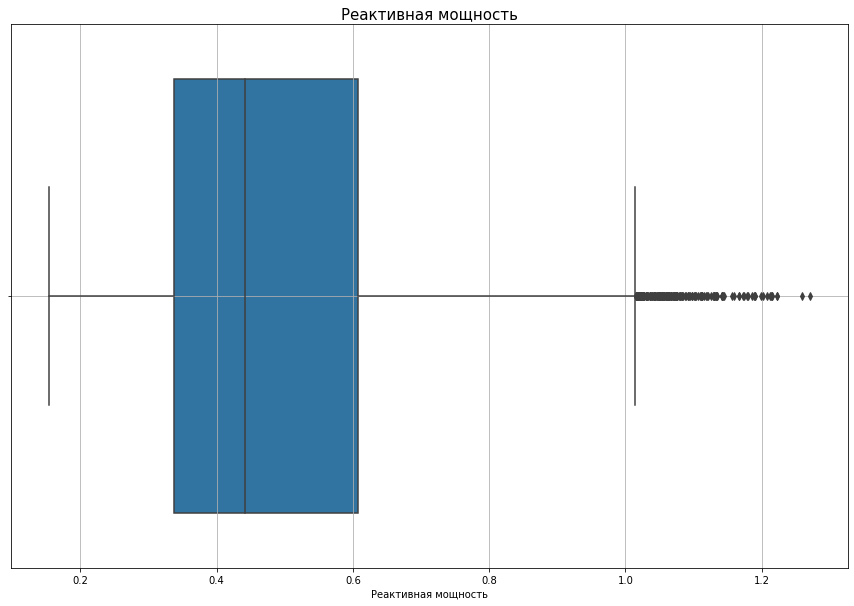

In [130]:
plt.figure(figsize=(15,10))
sns.boxplot(electrode['Реактивная мощность'])
plt.title('Реактивная мощность', fontsize=15)
plt.grid(True)
plt.show()

In [131]:
electrode[electrode['Реактивная мощность'] > 1.2].count()

key                     10
Начало нагрева дугой    10
Конец нагрева дугой     10
Активная мощность       10
Реактивная мощность     10
dtype: int64

Вывод: Были удалены явные выбросы в Реактивной мощности. Выбросы в газе решила не удалять, так как это могут быть особенности производства. 

### Замена пропусков

In [133]:
#syp_materials_ob - заменяю на 0


In [134]:
syp_materials_ob = syp_materials_ob.fillna(0)

In [135]:
syp_materials_ob

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [136]:
#provol_material_ob - заменяю на 0

In [137]:
provol_material_ob = provol_material_ob.fillna(0)

In [138]:
provol_material_ob

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Вывод: Заменила наны на нули, так как так будет лучше по условию бизнеса

### Перевод даты

In [155]:
#решила, ято данные с датой не понадобятся

### Расчет полной мощности

In [139]:
electrode['Полная мощность'] = np.sqrt(electrode['Активная мощность']**2 + electrode['Реактивная мощность']**2)

In [140]:
electrode

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,0.532085
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,0.792429
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,1.293389
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,0.641792


Вывод: рассчитала полную мощность для обучения

### Обьединение данных

In [ ]:
data = (provol_material_ob.merge(electrode, how = 'inner', on = 'key')
                 .merge(syp_materials_ob, how = 'inner', on = 'key')
                 .merge(gas, how = 'inner', on = 'key')
                 .merge(izmer_temp, how = 'inner', on = 'key')
                 .merge(provol_material_ob, how = 'inner', on = 'key')
                 
       )
data

In [142]:
#data.info()

In [143]:
pd.DataFrame(data.isna().sum(), columns = ['пропусков']).style.background_gradient()

,пропусков
key,0
Начало нагрева дугой_x,0
Конец нагрева дугой_x,0
Активная мощность_x,0
Реактивная мощность_x,0
Полная мощность_x,0
Начало нагрева дугой_y,0
Конец нагрева дугой_y,0
Активная мощность_y,0
Реактивная мощность_y,0


In [144]:
#display(data[['Активная мощность_x', 'Реактивная мощность_x',
 #      'Полная мощность_x',
  #     'Температура']].corr())

Вывод: обьединяю в один датасет по ключу. В Температуре много пропусков, удалю эти строки дальше, так как они не валидны для обучения.

### Удаление лишних признаков

In [145]:
data = data.drop(['Начало нагрева дугой_x',
                  'Конец нагрева дугой_x', 
                  'Активная мощность_x',
                  'Реактивная мощность_x'], axis = 1)

In [146]:
data = data.drop(['Начало нагрева дугой_y',
                  'Конец нагрева дугой_y',
                  'Активная мощность_y',
                  'Реактивная мощность_y'], axis = 1)
data 

,key,Полная мощность_x,Полная мощность_y,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,...,Температура,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,0.371123,0.371123,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,1571.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.371123,0.371123,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,1604.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.371123,0.371123,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,1618.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.371123,0.371123,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,1601.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.371123,0.371123,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,1606.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508802,3241,0.463185,0.463185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508803,3241,0.463185,0.463185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508804,3241,0.463185,0.463185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508805,3241,0.463185,0.463185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,63.117595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Корреляция 

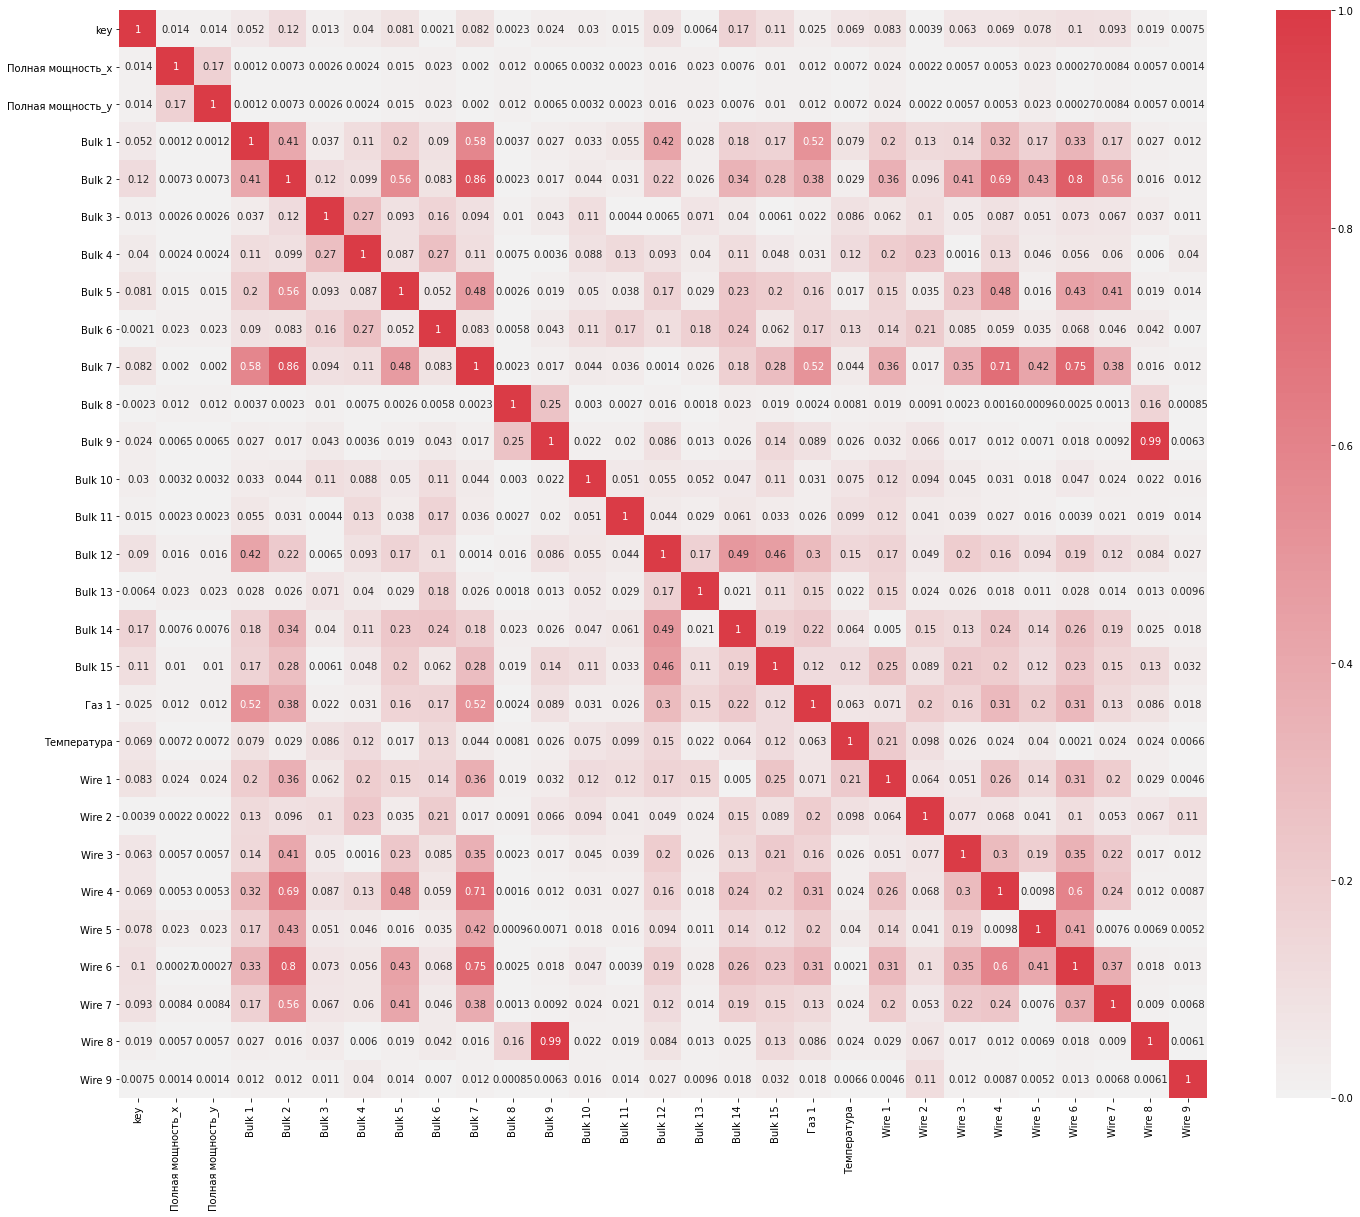

In [147]:
corr = abs(data.corr())

f, ax = plt.subplots(figsize=(25, 20))

font = {'size': 10}
plt.rc('font', **font)


cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(
    corr,          
    cmap=cmap,     
    annot=True,    
    vmax=1,       
    vmin=0,      
    center=0,      
    square=True,   
    linewidths=0, 
    xticklabels=True, yticklabels=True
)

In [150]:
data['Температура'] = data['Температура'].fillna(0)

In [151]:
data = data.query('Температура == 0')

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99876 entries, 391794 to 508806
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                99876 non-null  int64  
 1   Полная мощность_x  99876 non-null  float64
 2   Полная мощность_y  99876 non-null  float64
 3   Bulk 1             99876 non-null  float64
 4   Bulk 2             99876 non-null  float64
 5   Bulk 3             99876 non-null  float64
 6   Bulk 4             99876 non-null  float64
 7   Bulk 5             99876 non-null  float64
 8   Bulk 6             99876 non-null  float64
 9   Bulk 7             99876 non-null  float64
 10  Bulk 8             99876 non-null  float64
 11  Bulk 9             99876 non-null  float64
 12  Bulk 10            99876 non-null  float64
 13  Bulk 11            99876 non-null  float64
 14  Bulk 12            99876 non-null  float64
 15  Bulk 13            99876 non-null  float64
 16  Bulk 14         

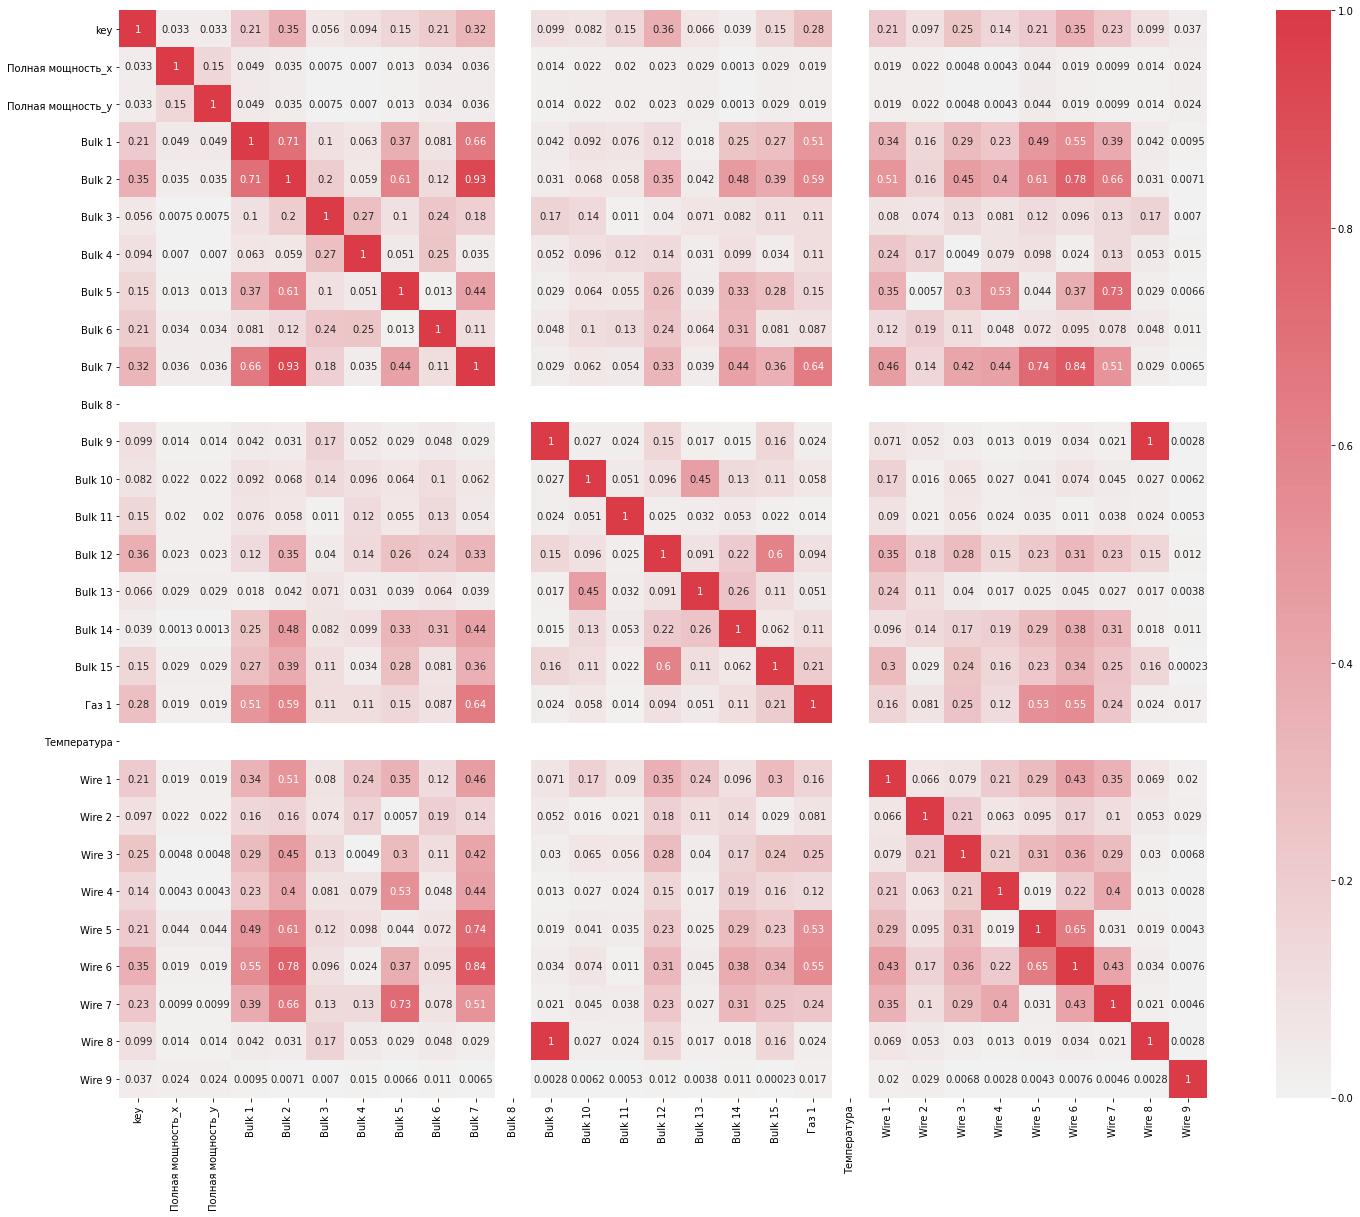

In [154]:
corr = abs(data.corr())

f, ax = plt.subplots(figsize=(25, 20))

font = {'size': 10}
plt.rc('font', **font)


cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(
    corr,          
    cmap=cmap,     
    annot=True,    
    vmax=1,       
    vmin=0,      
    center=0,      
    square=True,   
    linewidths=0, 
    xticklabels=True, yticklabels=True
)

Вывод:  Видны сильные зависимости и слабые. Но очень сильно коррелирует Bulk 9 и Wire 8.

## Вывод по предобработке данных

Были удалены выбросы

Заменены Nan значения на нули

Удалены лишние признаки

Проведена проверка корреляции

## Построение модели машинного обучения 

### выборка

In [159]:
features = data.drop(['Температура'],axis=1) 
target = data['Температура']
features_train, features_test, target_train, target_test= train_test_split(
features, target, test_size=0.25,shuffle=True, random_state=220523)

In [160]:
features_train.shape, features_test.shape

((74907, 29), (24969, 29))

In [163]:
numeric = data.columns.tolist()
numeric = [i for i in numeric if i not in ("Температура")]
scaler = MinMaxScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

ValueError: could not convert string to float: '2019-08-10 23:31:17'

### итог (старый)

предобработка:
-привести формат к datetime
-сделать все на английском
-узнать про пропуски и выбросы, что делать с nan, на что заменить,
что удалять
план:
-сделать предобработку
-сгруппировать датасеты
-удалить лишние признаки
-проверить на мультиколлинеарность
-выделить целевой признак
-построить и обучить модель
-проверить наилучшую модель на тестовой выборке



<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
С планом - ооооооо-очень лаконично. Сюда же можно включить проверку на мультиколлинеарность ДО моделирования и анализ важности факторов у модели-победителя). А если выходить на встречу с заказчиком, то подобный план лучше оформлять в виде списка.<br>